In [1]:
import torch
import models as m
import os
import json
import matplotlib.pyplot as plt
import torch.distributions as dist
import numpy as np
import math
import shutil


In [2]:
torch.set_default_dtype(torch.float32)

if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
    dtype = torch.FloatTensor
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
    
def t(x):
    # j'avais des problèmes de type avec les long 
    return torch.as_tensor(x, dtype=torch.get_default_dtype()).to(device)

print(device)


cuda:0


In [3]:
BASE_PATH = os.getcwd()
RUNS_ROOT = os.path.join(BASE_PATH, "runs")
EXP_NAME = "baseline"
EXP_DIR = os.path.join(RUNS_ROOT, EXP_NAME)
RUN_ID = '002'
RUN_DIR = os.path.join(EXP_DIR, RUN_ID)  
WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")
LOGS_DIR = os.path.join(RUN_DIR, "logs")
VIDEO_DIR = os.path.join(RUN_DIR, 'videos')

with open(os.path.join(LOGS_DIR, 'hparams.json')) as json_data:
    hparams = json.load(json_data)
    json_data.close()
   
hparams

{'batch_size': 512,
 'N_train': 15000,
 'EVAL_EVERY': 1000,
 'lr': 0.0001,
 'EPS_TRAINNING': False,
 'sigma': {'schedule': 'log',
  'min': 0.1,
  'max': 10,
  'n_sigmas': 10,
  'values': [10.0,
   5.994842529296875,
   3.59381365776062,
   2.1544346809387207,
   1.2915496826171875,
   0.7742636799812317,
   0.46415889263153076,
   0.2782559394836426,
   0.1668100506067276,
   0.10000000149011612]},
 'device': 'cuda:0',
 'model': {'x_dim': 2, 'hidden_dim': 1024, 'sigma_emb_dim': 100},
 'plot scores renormalisation': '0.5 + 25*i/n_sigma'}

In [4]:
SIGMAS = t(hparams['sigma']['values'])
EPS_TRAINNING = hparams['EPS_TRAINNING']
SCORE_NORM = np.load(os.path.join(LOGS_DIR,'score_norm.npy'))

In [5]:
w = torch.load(os.path.join(WEIGHTS_DIR, 'model.pt'),map_location=device,weights_only=True)
model = m.ScoreNetworkConditionned(
    x_dim = hparams['model']['x_dim'],
    hidden_dim=hparams['model']['hidden_dim'],
    sigma_emb_dim=hparams['model']['sigma_emb_dim']
)
model.load_state_dict(w)
model = model.to(device)
model.eval()

ScoreNetworkConditionned(
  (sigma_embedding): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (score_mlp): Sequential(
    (0): Linear(in_features=102, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [6]:
# pas de gradient ici pour ALD 
def make_score_from_model(model, sigma_scalar,eps_loss = False):
    sigma_scalar = float(sigma_scalar)
    
    @torch.no_grad()
    def score(x):
        # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar).to(device)   # (B,1) 
        return model(x, sigma)
    
    @torch.no_grad()
    def score_eps(x):
       # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma) /sigma
    if eps_loss : 
        return score_eps
    else : 
        return score

In [7]:
estimated_distribution_scores = [make_score_from_model(model,noise,EPS_TRAINNING) for noise in list(SIGMAS)]

In [8]:
def annealded_langevin_sampler_snr(prior, noisy_distrib_scores, noise_factor,SNR, norm, T, n_chain,save_dir=None):
    D = 2
    X = prior.sample((n_chain,)).to(device)
    PLOT_STEP_EVERY= 2
    
    if save_dir is not None:
        if os.path.exists(save_dir):
            shutil.rmtree(save_dir)   # supprime tout ce qu'il y a dedans (et le dossier)
        os.makedirs(save_dir)  
        
    frame = 0  # pour numéroter les images

    for i in range(len(noisy_distrib_scores)):
        tau = 2 * D * SNR / norm[i]
        noise_std = math.sqrt(2 * tau)   # niveau de bruit

        for step in range(T):
            
            X = X + tau * noisy_distrib_scores[i](X) + noise_std * torch.randn_like(X)

            if step % PLOT_STEP_EVERY == 0:
                plt.figure(figsize=(5,5))
                plt.xlim(-20,20)
                plt.ylim(-20,20)
                plt.scatter(X.T[0].cpu(), X.T[1].cpu())
                plt.title(f"sigma={noise_factor[i]:.3f} | " f"SNR={SNR:.2e} | " f"noise_std={noise_std:.2e}")

                if save_dir is not None:
                    fname = os.path.join(save_dir, f"frame_{frame:05d}.png")
                    plt.savefig(fname, dpi=150)
                    plt.close()
                else:
                    plt.show()

                frame += 1
    if save_dir is not None: 
        os.system(f"./make_ald_video.sh {save_dir} {SNR} {T}")
    return X

In [9]:
ALD_prior_mean = [0.0, 0.0]
ALD_prior_cov_scalar = 3       
ALD_step_size = 0.2
ALD_T = 1000
ALD_n_chain = 2000


In [10]:
prior_mean = t(ALD_prior_mean).to(device)
prior_var = ALD_prior_cov_scalar * torch.eye(2).to(device)
prior_distrib = dist.MultivariateNormal(prior_mean, covariance_matrix=prior_var)
OUTDIR = os.path.join(VIDEO_DIR,'out/')

In [22]:
SNR = 1

ALD_estimated_score = annealded_langevin_sampler_snr(
    prior_distrib,
    estimated_distribution_scores,
    SIGMAS,
    SNR,
    SCORE_NORM,
    T = 10,
    n_chain= 1000,
    save_dir= OUTDIR
)

ALD_ES_cpu = ALD_estimated_score.cpu()


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

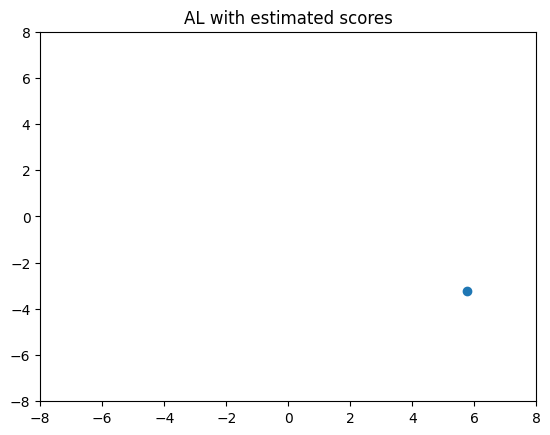

In [23]:

plt.title("Estimated distribution")
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('AL with estimated scores')
plt.scatter(ALD_ES_cpu.T[0],ALD_ES_cpu.T[1])
plt.show()